In [1]:
from __future__ import print_function ## Force python3-like printing

try:
    from importlib import reload
except:
    pass

%matplotlib inline
# %matplotlib notebook

from matplotlib import pyplot as plt

import os
import warnings

import numpy as np
from astropy.table import Table
from scipy.integrate import simps

import pycoco as pcc

reload(pcc) ## FOR DEV
reload(pcc.kcorr) ## FOR DEV
reload(pcc.functions) ## FOR DEV
reload(pcc.classes) ## FOR DEV
reload(pcc.colours)

warnings.resetwarnings() ## FOR DEV

In [2]:
V = pcc.functions.load_filter('/Users/berto/Code/CoCo/data/filters/BessellV.dat')
B = pcc.functions.load_filter('/Users/berto/Code/CoCo/data/filters/BessellB.dat')

vega = pcc.kcorr.load_vega()
AB = pcc.kcorr.load_AB()

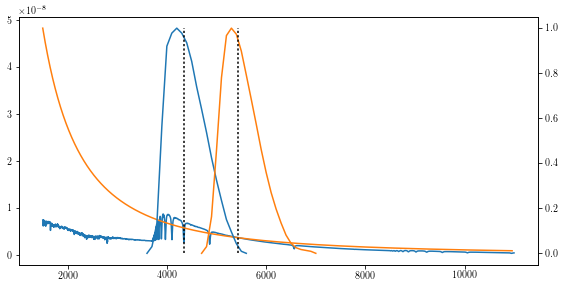

In [37]:
fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.99, hspace=0, wspace = 0)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(vega.wavelength, vega.flux)
ax1.plot(AB.wavelength, AB.flux)

ax2.plot(B.wavelength, B.throughput)
ax2.plot([B.lambda_effective.value, B.lambda_effective.value], [0,1], color = pcc.colours.hex["black"], ls = ":")
ax2.plot(V.wavelength, V.throughput)
ax2.plot([V.lambda_effective.value, V.lambda_effective.value], [0,1], color = pcc.colours.hex["black"], ls = ":")


Test whether the scaling matches that in Bohlin & Gilliland, 2004, AJ, 127, 3508 (the source of the spectrum) i.e. absolute flux level is 3.46 × 10-9 ergs cm-2 s-1 at 5556 Angstroms

In [4]:
vega.data[np.logical_and(vega.data["wavelength"] > 5550., vega.data["wavelength"] < 5560.)]

wavelength,flux
Angstrom,erg / (Angstrom cm2 s)
float64,float64
5555.0,3.464e-09


Want to find the flux in a given band, take Bessell V as an example.

In [5]:
filter_name = "BessellV"
filter_object = pcc.kcorr.load_filter("/Users/berto/Code/CoCo/data/filters/" + filter_name + ".dat")

Resample the filter wavelength to that of the spectrum, and calculate the resulting transmission

In [6]:
filter_object.resample_response(new_wavelength = AB.wavelength)
transmitted_spec = filter_object.throughput * AB.flux

In [7]:
integrated_flux = simps(transmitted_spec, AB.wavelength)

print(integrated_flux)

3.24042605185e-06


In [8]:
filter_area = simps(filter_object.throughput, filter_object.wavelength)

In [9]:
zp_AB = -2.5*np.log10(integrated_flux/filter_area)
print(zp_AB)

21.1007662906


These steps are combined in **`pycoco.kcorr.calc_AB_zp()`**

In [10]:
print(pcc.kcorr.calc_AB_zp("BessellV"))

21.1011399643


Equivalently, for Vega Magnitudes - **`pycoco.calc_vega_zp`**

In [11]:
print(pcc.kcorr.calc_vega_zp("BessellV"))

21.1063492424


$m = -2.5log_{10}(F) - m_{zp}$

so

$F = 10^{\frac{m - m_{zp}}{-2.5}}$

and 

$\Delta F = 1.086F \frac{\Delta m}{m}$

In [17]:
sn = pcc.classes.SNClass("SN2006aj")
sn.load_phot( path = os.path.join(pcc.defaults._default_data_dir_path,"lc/SN2006aj.dat"))
sn.load_list(os.path.join(pcc.defaults._default_coco_dir_path, "lists/SN2006aj.list"))
# sn.load_spec()
# sn.check_overlaps()
# sn.get_lcfit("/Users/berto/Code/CoCo/recon/SN2006aj.dat")

/Users/berto/Code/CoCo/data/lc/SN2006aj.dat


In [18]:
sn.phot.load(os.path.join(pcc.defaults._default_data_dir_path,"lc/SN2006aj.dat"))

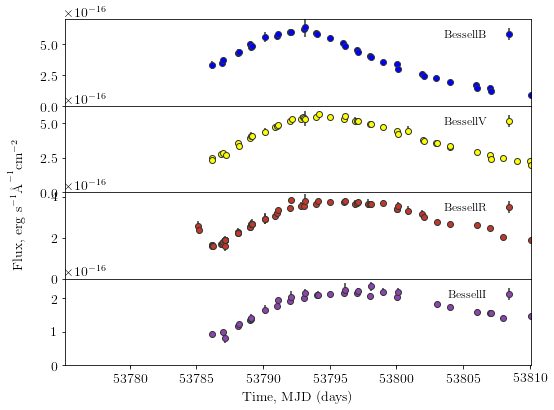

In [19]:
sn.plot_lc()

In [20]:
mag = -2.5*np.log10(sn.phot.data['BessellV']["flux"]) - zp_AB + 0.2
t = sn.phot.data['BessellV']["MJD"]

for i in zip(t, mag):
    print(i)

(53786.161999999997, 18.11823445263655)
(53786.207999999999, 18.168233416286597)
(53786.878700000001, 17.998232374372812)
(53787.032299999999, 17.978233217608427)
(53787.196000000004, 18.008234672141633)
(53788.127699999997, 17.728232521902825)
(53788.186000000002, 17.778234046610692)
(53789.0573, 17.608233099005275)
(53789.126600000003, 17.57823423011056)
(53789.196000000004, 17.57823423011056)
(53790.127500000002, 17.498233866900861)
(53790.871299999999, 17.418233932019874)
(53791.048300000002, 17.388233531073041)
(53791.112000000001, 17.37823310260972)
(53792.041299999997, 17.318234564798807)
(53792.139999999999, 17.288234747053679)
(53792.872000000003, 17.288234747053679)
(53793.015599999999, 17.258234485020708)
(53793.049700000003, 17.268233224970075)
(53793.167000000001, 17.278233583930252)
(53794.005299999997, 17.258234485020708)
(53794.167999999998, 17.208233052823445)
(53795.035300000003, 17.258234485020708)
(53796.031300000002, 17.278233583930252)
(53796.142999999996, 17.2482

In [18]:
import pycoco.litdata as plit

In [124]:
def get_lit_sn(snname = "2006aj"):
    lit_sn = OrderedDict()
    
    data = plit.load_CfA_phot_table()
    
    sndata = data[np.where(data["SN"] == snname)]

In [125]:
snname = "2006aj"
data = plit.load_CfA_phot_table()
sndata = data[np.where(data["SN"] == snname)]

In [127]:
sndata[np.where(sndata["Filter"] == "BessellV")]

SN,MJD,mag,e_mag,Code,Filter,EBV
str6,float64,float64,float64,str9,str8,float64
2006aj,53788.12746,18.079,0.046,CfA3_KEP,BessellV,0.1267
2006aj,53790.11067,17.722,0.03,CfA3_KEP,BessellV,0.1267
2006aj,53790.12778,17.74,0.024,CfA3_KEP,BessellV,0.1267
2006aj,53791.1203,17.631,0.019,CfA3_KEP,BessellV,0.1267
2006aj,53791.13345,17.654,0.021,CfA3_KEP,BessellV,0.1267
2006aj,53792.12275,17.547,0.026,CfA3_KEP,BessellV,0.1267
2006aj,53792.13554,17.595,0.023,CfA3_KEP,BessellV,0.1267
2006aj,53793.12243,17.546,0.018,CfA3_KEP,BessellV,0.1267
2006aj,53793.13649,17.513,0.018,CfA3_KEP,BessellV,0.1267


In [157]:
import pycoco
isinstance(pycoco.classes.FilterClass, FilterClass)

False

In [158]:
from pycoco.classes import FilterClass